In [360]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as lm

pd.get_option("display.max_columns", None)

20

# Final Project: Question 2

- Which factors affect the monetary rewards of appealing? 
- What influences how much money one might gain from a successful appeal?

Utilize multivariate OLS. Our goal is to understand whether there is bias or unfairness in the tax system.

In [361]:
df = pd.read_csv('project2data.csv')

print('Dataset Description:')
print(' Original Format: comma-separated values file')
print(' Observations: Random sample of property tax appeals within Cook County')
print(' Number of observations (rows):', df.shape[0])
print(' Number of features (columns):', df.shape[1])
print(' Feature names:  ',
      ', '.join([(element + "\n\t\t") if (index % 4 ==0) else element \
                for index, element in enumerate(sorted(df.columns), start=1)]))
print(" Dependent variable: appeal")
print("   *appeal = dollar amount deducted from assessed value after property owner appealed. If NA there was no appeal.")
print(" Source: Cook County Assessor's Office")
print(' Contact: datascience@cookcountyassessor.com')

Dataset Description:
 Original Format: comma-separated values file
 Observations: Random sample of property tax appeals within Cook County
 Number of observations (rows): 19036
 Number of features (columns): 26
 Feature names:   appeal, asian, av1, avg_school_score
		, beds, black, college, condo
		, elem_score, high_school_score, hispanic, homeowner
		, medhinc, pcity, pdir, pin14
		, poverty, pstreet, squarefoot, taxes
		, tcity, tri, value, walkfac
		, walkscore, white
 Dependent variable: appeal
   *appeal = dollar amount deducted from assessed value after property owner appealed. If NA there was no appeal.
 Source: Cook County Assessor's Office
 Contact: datascience@cookcountyassessor.com


# Data Quality - Review Preprocessing

Take a high-level review of the data and remap when necessary.

In [362]:
# Review continuous features
df.describe()

,pin14,av1,value,taxes,homeowner,white,black,hispanic,asian,medhinc,poverty,college,squarefoot,beds,walkscore,elem_score,high_school_score,avg_school_score,appeal
count,1.903600e+04,1.899100e+04,1.903600e+04,19036.000000,19036.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,13915.000000,13915.000000,19036.000000,19036.000000,19036.000000,19036.000000,9.018000e+03
mean,1.806325e+13,3.036896e+04,3.564597e+05,4972.586580,0.426087,0.625657,0.205279,0.186143,0.139870,67020.153960,0.135024,0.318044,1908.737478,3.648653,69.779838,5.453719,5.394883,5.644411,5.394141e+03
std,5.788279e+12,2.961622e+04,3.641909e+05,4233.282368,0.494520,0.274867,0.296543,0.214204,0.118632,26266.301109,0.099465,0.212173,1167.077974,1.701771,23.504392,2.406259,2.865633,2.223499,2.029286e+04
min,9.253050e+12,-1.045572e+06,5.000000e+03,0.000000,0.000000,0.001088,0.000789,0.001889,0.000000,9550.000000,0.003604,0.004178,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00
25%,1.418130e+13,1.534750e+04,1.750000e+05,2479.315050,0.000000,0.499139,0.020925,0.053135,0.053844,47972.000000,0.065292,0.134969,1151.000000,3.000000,55.000000,3.000000,3.000000,4.000000,0.000000e+00
50%,1.704110e+13,2.367500e+04,2.660000e+05,3940.760000,0.000000,0.703167,0.051095,0.091340,0.099713,63529.000000,0.112022,0.265332,1567.000000,3.000000,75.000000,6.000000,5.000000,6.000000,1.177500e+03
75%,2.016100e+13,3.680350e+04,4.130000e+05,6088.760125,1.000000,0.851731,0.261715,0.217768,0.194202,84167.000000,0.170868,0.505770,2297.000000,4.000000,89.000000,7.000000,8.000000,7.000000,4.375000e+03
max,3.331210e+13,7.639090e+05,1.500000e+07,133258.690000,1.000000,0.970822,0.993390,0.979010,0.896609,192143.000000,0.776376,0.766168,27270.000000,24.000000,100.000000,10.000000,10.000000,10.000000,1.164486e+06


In [363]:
# Drop duplicate rows
print("Total df row count: ",len(df))
print("Row count after dropping duplicate rows: ", len(df.drop_duplicates()))
df = df.drop_duplicates()

Total df row count:  19036
Row count after dropping duplicate rows:  18904


In [364]:
# Data Quality Review for each feature individually and remap when necessary
for feature in sorted(list(df.columns)):
    # Feature Summary section
    print(feature,':  data type:',str(df.dtypes[feature]))
    print('       unique values:',len(df[feature].unique()))
    if len(df[feature].unique()) < 20 and not isinstance(df[feature], str):
        print("    Original unique values for review:", str(df[feature].unique()))
    
    if feature == 'walkfac':
        Walkfac_dict = {'Car-Dependent': '1',
                        'Somewhat Walkable': '2',
                        'Very Walkable': '3',
                        "Walker's Paradise": '4'
                            }
        df[feature] = df[feature].map(Walkfac_dict)
        print("    New unique values for review:", str(sorted(df[feature].unique())))
    if feature == 'condo':
        Walkfac_dict = {'Non-condo': 0,
                        'Condominium': 1
                            }
        df[feature] = df[feature].map(Walkfac_dict)
        print("    New unique values for review:", str(sorted(df[feature].unique())))
    if feature == 'tri':
        # Convert data type to category
        df[feature] = df[feature].astype('category')
        print("New data type:",str(df.dtypes[feature]) )    
    if feature == 'pin14':
        # Convert data type to category
        df[feature] = df[feature].astype('str')
        print("New data type:",str(df.dtypes[feature]))

appeal :  data type: float64
       unique values: 4302
asian :  data type: float64
       unique values: 1108
av1 :  data type: float64
       unique values: 15796
avg_school_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 4  9  2  6  8  3  7  5  1 10]
beds :  data type: float64
       unique values: 21
black :  data type: float64
       unique values: 1110
college :  data type: float64
       unique values: 1109
condo :  data type: object
       unique values: 2
    Original unique values for review: ['Non-condo' 'Condominium']
    New unique values for review: [0, 1]
elem_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 1 10  5  8  2  7  4  9  6  3]
high_school_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 6  8  2 10  1  5  4  9  7  3]
hispanic :  data type: float64
       unique values: 1110
homeowner :  data type: int64
       unique values: 2
    Or

In [365]:
# Break pin14 feature into subcomponents and drop
# Per docs:
# All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode
# NOTE: Docs do not account for meaning of full 14 digits (above adds up to 12; unclear of any meaning for last 2 digits)
df['area']      = df.pin14.str[0:2]
df['subarea']   = df.pin14.str[2:4]
df['block']     = df.pin14.str[4:6]
df['parcel']    = df.pin14.str[6:8]
df['multicode'] = df.pin14.str[8:12]
df = df.drop(columns='pin14')

# Review feature unique values
for feature in ['area','subarea','block','parcel','multicode']:
    # Feature Summary section
    print(feature, '  unique values:',len(df[feature].unique()))
    if len(df[feature].unique()) < 20 and not isinstance(df[feature], str):
        print("    Original unique values for review:", str(df[feature].unique()))

# Drop less useful features based on low cardinality
df = df.drop(columns='parcel')
df = df.drop(columns='multicode')

area   unique values: 26
subarea   unique values: 42
block   unique values: 41
parcel   unique values: 1
    Original unique values for review: ['00']
multicode   unique values: 1
    Original unique values for review: ['0000']


In [366]:
# Encode categorical features; Always drop one column to prevent multicollinearity issues
df = pd.get_dummies(df, columns=['walkfac'], prefix='walkfac', prefix_sep='_', drop_first=True)
df = pd.get_dummies(df, columns=['tri'], prefix='tri', prefix_sep='_', drop_first=True)

In [367]:
# create tax rate (Jeff's code)
df['tax_rate'] = df['taxes'] / df['value'] * 100
df = df.drop(columns='taxes')

## Data Quality - Missingness

Assess and handle missing data

In [368]:
# Review missingness
print("Feature_________________Missing Value Count")
print(df.isna().sum())
print("\ndf row count:",len(df))

Feature_________________Missing Value Count
pdir                                  5439
pstreet                                  1
pcity                                    1
tcity                                    0
condo                                    0
av1                                     45
value                                    0
homeowner                                0
white                                  122
black                                  122
hispanic                               122
asian                                  122
medhinc                                122
poverty                                122
college                                122
squarefoot                            5118
beds                                  5118
walkscore                                0
elem_score                               0
high_school_score                        0
avg_school_score                         0
appeal                                9982
area      

In [369]:
# We only need those who appealed for this question (>=0); drop those who did not appeal (NaN)
df = df[df.appeal.notnull()]
print("Row count after dropping null appeal observations:",len(df))

Row count after dropping null appeal observations: 8922


In [370]:
# Drop features based on missingness (>10%) (not candidate for imputation)
## squarefoot and beds are each missing 2567 observations; missingness has 1-1 correlation
df = df.drop(columns='pdir')       # Missing 2353/8922 
df = df.drop(columns='squarefoot') # Missing 2567/8922 
df = df.drop(columns='beds')       # Missing 2567/8922 

In [371]:
# Manual review finds missingness is 1-1 for white, black, hispanic, asian, medhinc, poverty, and college features.
## Missing 91/8922 observations (~1%); opted to drop these.
df = df[df.college.notnull()]

In [372]:
# Review missingness of data; final row count 8831
print("Feature_________________Missing Value Count")
print(df.isna().sum())
print("\ndf row count:",len(df))

Feature_________________Missing Value Count
pstreet                               0
pcity                                 0
tcity                                 0
condo                                 0
av1                                   0
value                                 0
homeowner                             0
white                                 0
black                                 0
hispanic                              0
asian                                 0
medhinc                               0
poverty                               0
college                               0
walkscore                             0
elem_score                            0
high_school_score                     0
avg_school_score                      0
appeal                                0
area                                  0
subarea                               0
block                                 0
walkfac_2                             0
walkfac_3                           

## EDA

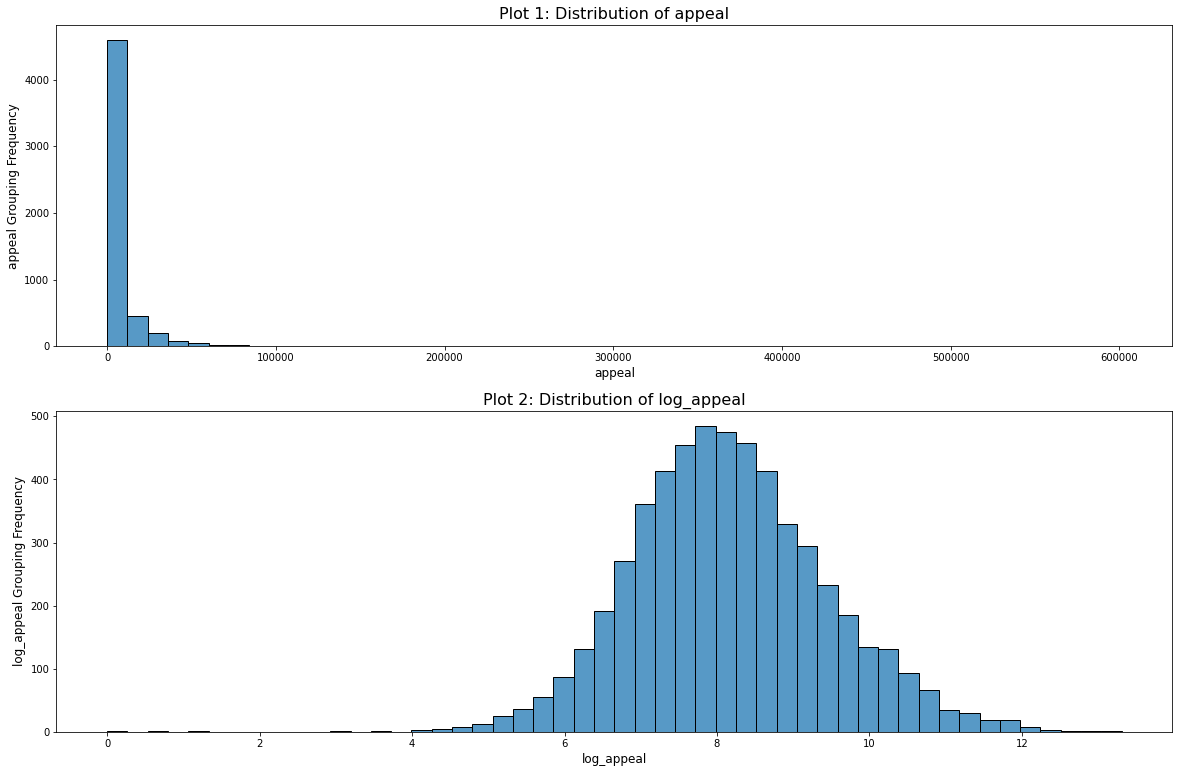

In [373]:
# Create new feature log_appeal
# ## Exclude where appeal = 0 because these are unsuccessful appeals (no monetary reward).
df = df[(df['appeal']>0)]
df['log_appeal'] = np.log(df['appeal'])

# Review dependent variable: appeal
plt.figure(figsize=(20,13))
plt.subplot(2, 1, 1)
ax1 = sns.histplot(df["appeal"], bins = 50, kde=False)
ax1.set_xlabel("appeal",fontsize=12)
ax1.set_ylabel("appeal Grouping Frequency",fontsize=12)
ax1.set_title('Plot 1: Distribution of appeal',fontsize=16)
plt.subplot(2, 1, 2)
ax1 = sns.histplot(df["log_appeal"], bins = 50, kde=False)
ax1.set_xlabel("log_appeal",fontsize=12)
ax1.set_ylabel("log_appeal Grouping Frequency",fontsize=12)
ax1.set_title('Plot 2: Distribution of log_appeal',fontsize=16)
plt.show()

# Drop appeal
df = df.drop(columns='appeal') 

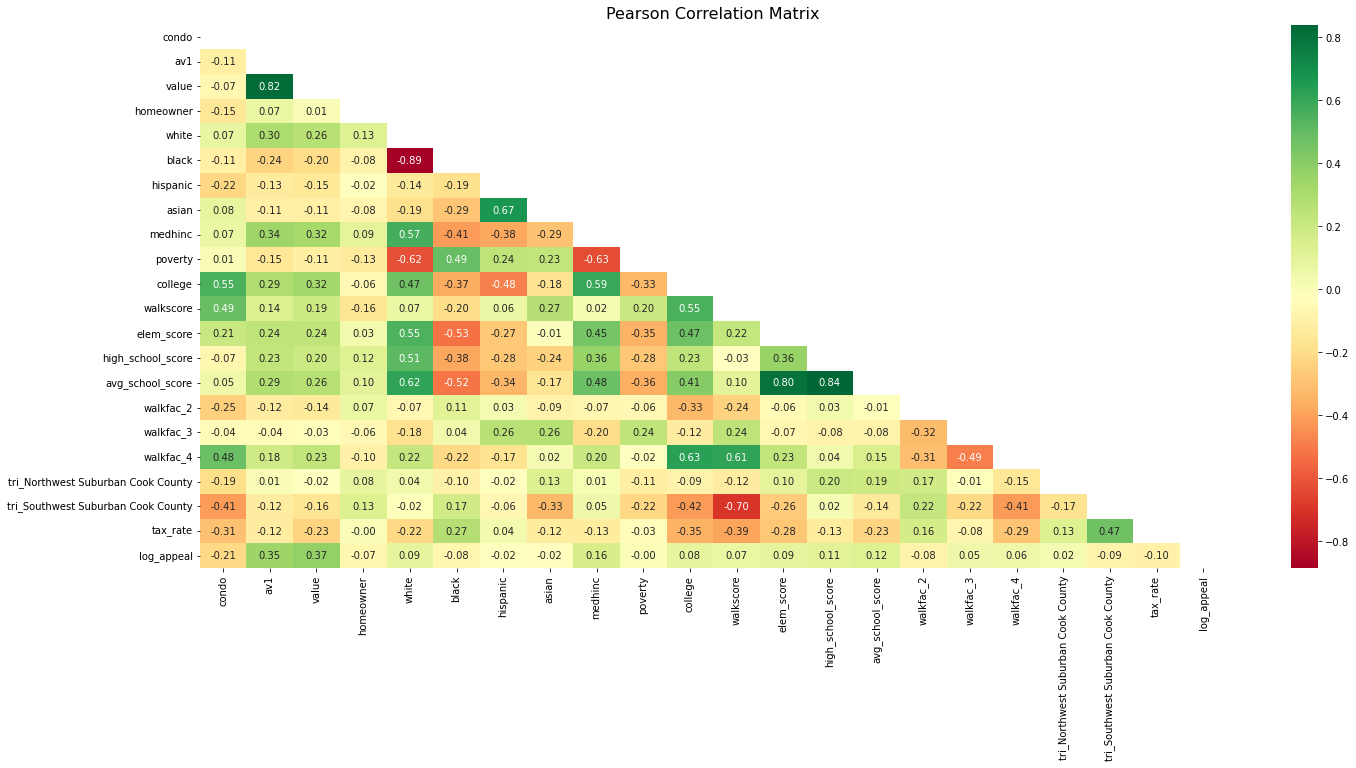

In [374]:
plt.figure(figsize=(23,10))
corr = df.corr(method='pearson')

# Retrieve lower left section matrix
matrix = np.triu(corr)

ax = sns.heatmap(corr, 
                 xticklabels=corr.columns.values,
                 yticklabels=corr.columns.values,
                 annot=True, 
                 fmt='.2f',
                 cmap='RdYlGn',
                 mask=matrix)
ax.set_title('Pearson Correlation Matrix',fontsize=16)
plt.show()

# Additional Preprocessing

In [375]:
# Convert all continuous features to float32 (aligns w/ regression modeling package requirements in next section)
cols = ['condo', 'av1', 'value', 'homeowner',
       'white', 'black', 'hispanic', 'asian', 'medhinc', 'poverty', 'college',
       'walkscore', 'elem_score', 'high_school_score', 'avg_school_score',
       'area', 'subarea', 'block', 'walkfac_2', 'walkfac_3', 'walkfac_4',
       'tri_Northwest Suburban Cook County',
       'tri_Southwest Suburban Cook County', 'tax_rate', 'log_appeal'
       ]
for col in cols:
    df[col] = df[col].astype('float32')

# Removes spaces in col name
df.rename(columns={'tri_Southwest Suburban Cook County': 'tri_SouthwestSuburbanCookCounty', 'tri_Northwest Suburban Cook County': 'tri_NorthwestSuburbanCookCounty'}, inplace=True)

In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5474 entries, 2 to 19035
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pstreet                          5474 non-null   object 
 1   pcity                            5474 non-null   object 
 2   tcity                            5474 non-null   object 
 3   condo                            5474 non-null   float32
 4   av1                              5474 non-null   float32
 5   value                            5474 non-null   float32
 6   homeowner                        5474 non-null   float32
 7   white                            5474 non-null   float32
 8   black                            5474 non-null   float32
 9   hispanic                         5474 non-null   float32
 10  asian                            5474 non-null   float32
 11  medhinc                          5474 non-null   float32
 12  poverty            

In [377]:
# Scale continuous features (normalization); Reduces model weighting on value size
# cols_to_norm = [
#   'av1', 'value', 'white', 'black', 'hispanic', 'asian',
#   'medhinc', 'poverty', 'college', 'walkscore', 'elem_score',
#   'high_school_score', 'avg_school_score', 'tax_rate'
#   ,'area', 'subarea', 'block'
#   ]
# df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [378]:
# Move log_appeal to first position
first_column = df.pop('log_appeal')
df.insert(0, 'log_appeal', first_column)

# Remove unwieldy string columns
df = df.drop(columns=['pstreet', 'pcity', 'tcity']) 

# Remove poorly defined column per Jeff's conversation w/ TA
df = df.drop(columns='av1') 

df.head()

,log_appeal,condo,value,homeowner,white,black,hispanic,asian,medhinc,poverty,...,avg_school_score,area,subarea,block,walkfac_2,walkfac_3,walkfac_4,tri_NorthwestSuburbanCookCounty,tri_SouthwestSuburbanCookCounty,tax_rate
2,8.342602,0.0,1364225.0,0.0,0.507349,0.214669,0.096806,0.244488,32930.0,0.263047,...,4.0,14.0,8.0,42.0,0.0,1.0,0.0,0.0,0.0,0.853575
3,10.574108,0.0,1091500.0,0.0,0.884098,0.015355,0.087505,0.063736,92589.0,0.011499,...,9.0,14.0,19.0,13.0,0.0,1.0,0.0,0.0,0.0,0.294599
7,9.189424,0.0,905000.0,1.0,0.884189,0.048890,0.040915,0.048544,85528.0,0.079787,...,8.0,14.0,33.0,41.0,0.0,0.0,1.0,0.0,0.0,0.969112
8,10.228140,0.0,656250.0,0.0,0.685848,0.083346,0.254261,0.178264,62623.0,0.142172,...,6.0,14.0,5.0,32.0,0.0,0.0,1.0,0.0,0.0,1.581288
9,8.032685,0.0,355000.0,0.0,0.628940,0.039828,0.495415,0.264470,51393.0,0.137874,...,3.0,13.0,13.0,30.0,0.0,1.0,0.0,0.0,0.0,1.852642


## Analysis Section

### Bivariate Linear Regression Models

In [379]:
print('Dependent Variable: log_appeal')

features = []
rsquared = []
rsquared_adj = []
pvalues = []
SER=[]
columns = list(df.columns)
columns.remove('log_appeal')

for col in columns:
    formula = "log_appeal ~ " + col
    model = smf.ols(formula=formula, data=df) 
    results = model.fit()
    features.append(col)
    rsquared.append(round(results.rsquared,4))
    rsquared_adj.append(round(results.rsquared_adj,4))
    pvalues.append(round(results.pvalues[0],6))
    SSR=0
    n = len(df)
    for x,y in zip(df["log_appeal"], df[col]):
        predicted_y = results.params[0]+results.params[1]*x
        SSR = (y-predicted_y)**2 + SSR
    SER.append((SSR/(n-2))**(1/2))

# initialize dict of lists.
data = {'features': features,
        'rsquared': rsquared,
        'rsquared_adj': rsquared_adj,
        'p_value': pvalues,
        "SER": SER}
 
# Create dataframe & display for review
linear_model_stats = pd.DataFrame(data)
linear_model_stats.sort_values(by=['rsquared_adj'], ascending=False).head(50)


Dependent Variable: log_appeal


,features,rsquared,rsquared_adj,p_value,SER
1,value,0.1404,0.1403,0.0,636016.834124
0,condo,0.0453,0.0451,0.0,3.319819
7,medhinc,0.0241,0.0240,0.0,78008.621849
13,avg_school_score,0.0150,0.0148,0.0,3.039148
12,high_school_score,0.0114,0.0112,0.0,3.680016
14,area,0.0097,0.0096,0.0,11.703930
22,tax_rate,0.0096,0.0094,0.0,5.845366
11,elem_score,0.0081,0.0079,0.0,3.262743
3,white,0.0076,0.0074,0.0,10.995616
21,tri_SouthwestSuburbanCookCounty,0.0074,0.0073,0.0,5.948324


In [381]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared

    https://planspace.org/20150423-forward_selection_with_statsmodels/
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

model = forward_selected(df, 'log_appeal')

print(model.model.formula)

print("\n Adjusted R-squared:",model.rsquared_adj)
print(model.summary())

log_appeal ~ value + condo + tri_SouthwestSuburbanCookCounty + homeowner + medhinc + walkfac_2 + poverty + tax_rate + area + walkfac_4 + walkfac_3 + walkscore + hispanic + tri_NorthwestSuburbanCookCounty + asian + high_school_score + 1

 Adjusted R-squared: 0.21757731369344402
                            OLS Regression Results                            
Dep. Variable:             log_appeal   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     96.12
Date:                Sat, 26 Feb 2022   Prob (F-statistic):          3.45e-279
Time:                        17:00:21   Log-Likelihood:                -8447.8
No. Observations:                5474   AIC:                         1.693e+04
Df Residuals:                    5457   BIC:                         1.704e+04
Df Model:                          16                                         
Covariance 